In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from itertools import combinations
import anndata
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

import plotting_functions as pf

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
plate_palette = sns.color_palette("husl", n_colors=3)
sex_palette = ['hotpink','dodgerblue']
geno_palette = ['#DA9CC1', '#F4C245', '#C0BFBF', '#55AF5B', '#4F6EAF', '#52A5DB', '#D83026', '#683C91']


# QC plotting - 200 UMI merged adata

In [3]:
adata = sc.read("../IGVF_analysis/preprocessed_tissues/Gastrocnemiuspreprocessed.h5ad")


In [4]:
adata.layers['raw_counts'] = adata.X.copy()


In [5]:
adata

AnnData object with n_obs × n_vars = 1515446 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'doublet_scores', 'batch'
    var: 'gene_name'
    layers: 'raw_counts'

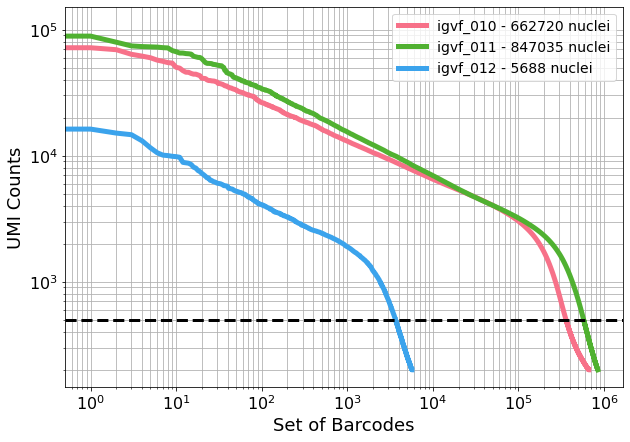

In [6]:
pf.plot_knee(adata, cutoff=500, category_column='plate', figsize=(10, 7))
plt.show()

In [7]:
# set var names to be gene names, not gene ID
adata.var_names  = adata.var['gene_name']
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


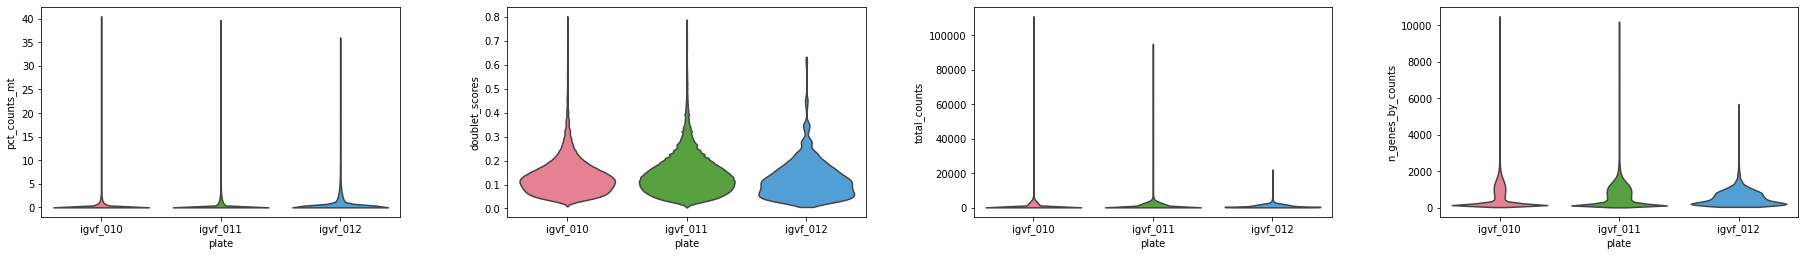

In [8]:
plate_palette = sns.color_palette("husl", n_colors=3)

sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "plate", palette = plate_palette,
             jitter=0.4, multi_panel=True, size=0)

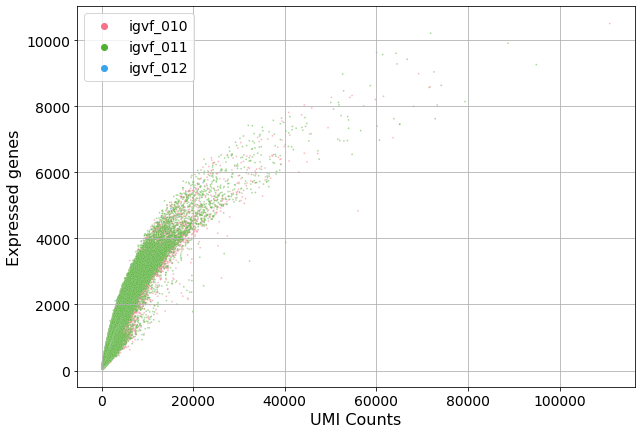

In [9]:
pf.plot_genes_by_counts(adata, category_column='plate', figsize=(10, 7))
plt.show()

In [10]:
adatas = adata[(adata.obs['total_counts'] < 10000) & (adata.obs['n_genes_by_counts'] < 2000), :]


/opt/apps/python/3.8.0/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


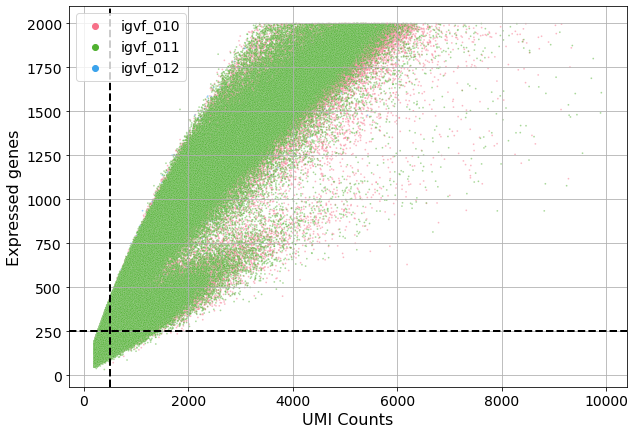

In [11]:
pf.plot_genes_by_counts(adatas, category_column='plate', figsize=(10, 7))

plt.axvline(x=500, color='k', linestyle='--', linewidth=2)
plt.axhline(y=250, color='k', linestyle='--', linewidth=2)

plt.show()

In [12]:
adatas[(adatas.obs['total_counts'] > 500) & (adatas.obs['n_genes_by_counts'] < 250), :]


View of AnnData object with n_obs × n_vars = 68711 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw_counts'

# QC plotting - filtered data
500 UMI, 250 genes, 1% mito, 0.25 doublet score


In [79]:
adata = sc.read("../IGVF_analysis/tissue_processed_500umi/Gastrocnemius_processed.h5ad")


In [80]:
# what happened to cell ID ;__;
adata.obs['cellID'] = (
    adata.obs['bc1_well'].astype(str) + "_" +
    adata.obs['bc2_well'].astype(str) + "_" +
    adata.obs['bc3_well'].astype(str) + "_" +
    adata.obs['subpool'].astype(str) + "_" +
    adata.obs['plate'].astype(str)
)


In [81]:
adata.layers

Layers with keys: raw_counts

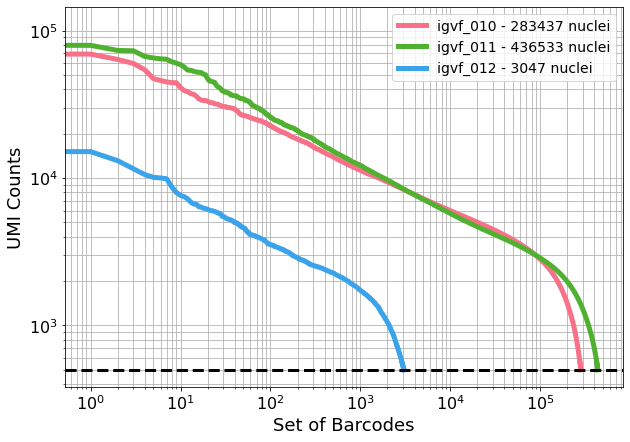

In [82]:
pf.plot_knee(adata, cutoff=500, category_column='plate', figsize=(10, 7))
plt.show()

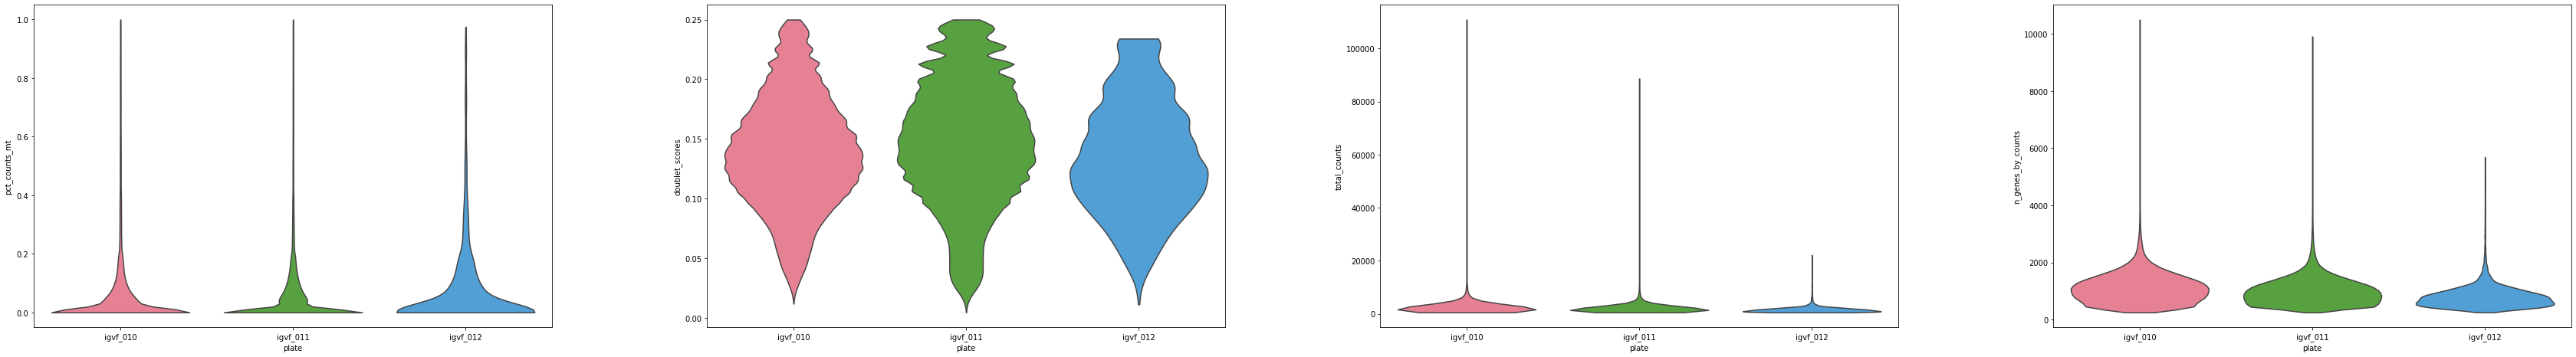

In [83]:
sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "plate", palette = plate_palette,
             jitter=0.4, multi_panel=True, size=0)

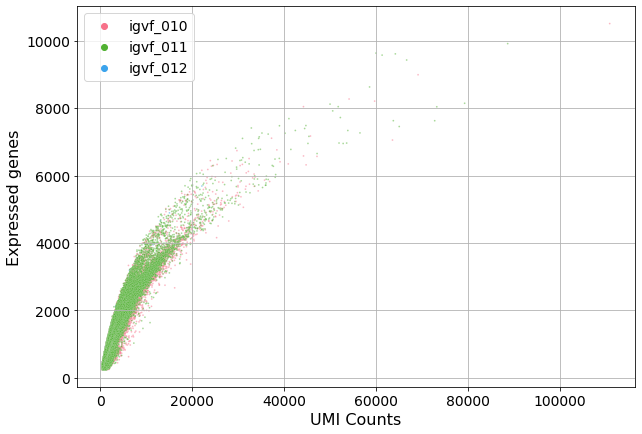

In [84]:
pf.plot_genes_by_counts(adata, category_column='plate', figsize=(10, 7))
plt.show()

In [85]:
print(adata.obs['Genotype'].value_counts())

adata = adata[adata.obs['Genotype'] != "tie",:]

print(adata.obs['Genotype'].value_counts())

Genotype
NODJ      108800
PWKJ      107368
NZOJ       91214
AJ         89049
CASTJ      87720
WSBJ       87555
129S1J     79720
B6J        70502
tie         1092
Name: count, dtype: int64
Genotype
NODJ      108800
PWKJ      107368
NZOJ       91214
AJ         89049
CASTJ      87720
WSBJ       87555
129S1J     79720
B6J        70502
Name: count, dtype: int64


# Check clustering
Plate, sex, genotype

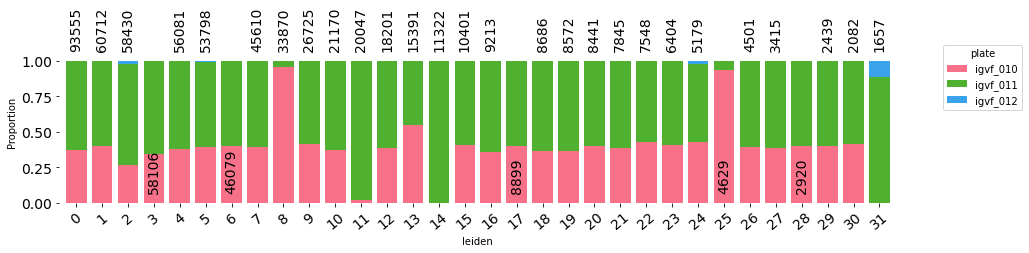

In [86]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'plate',
                            flip=False, fsize = (15,3), 
                            annotations = True)


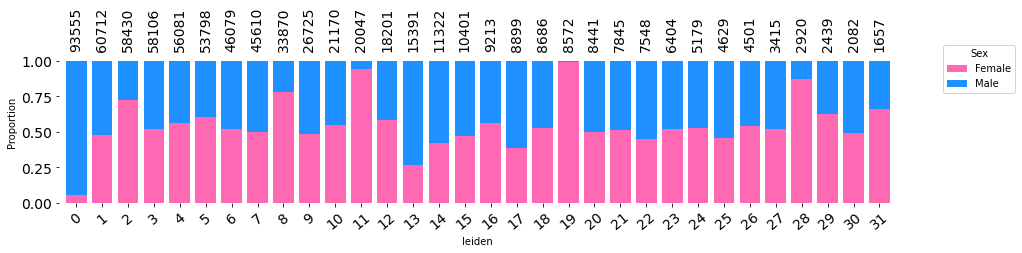

In [87]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Sex',
                            flip=False, fsize = (15,3), 
                            annotations = True)


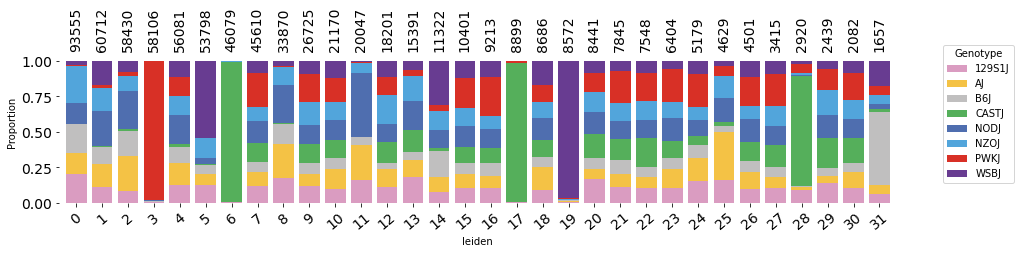

In [88]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Genotype',
                            flip=False, fsize = (15,3), 
                            annotations = True)


/opt/apps/python/3.8.0/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/opt/apps/python/3.8.0/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


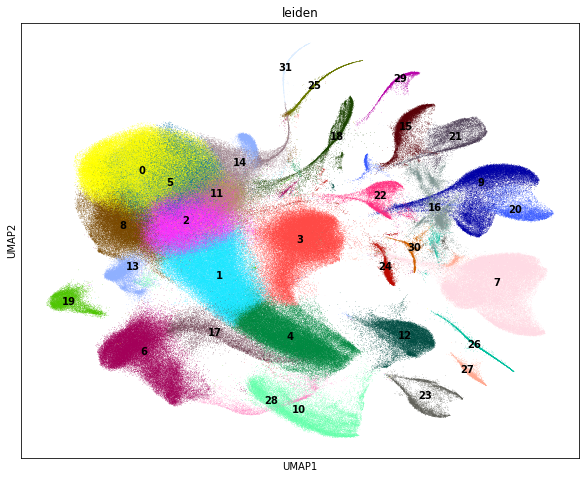

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


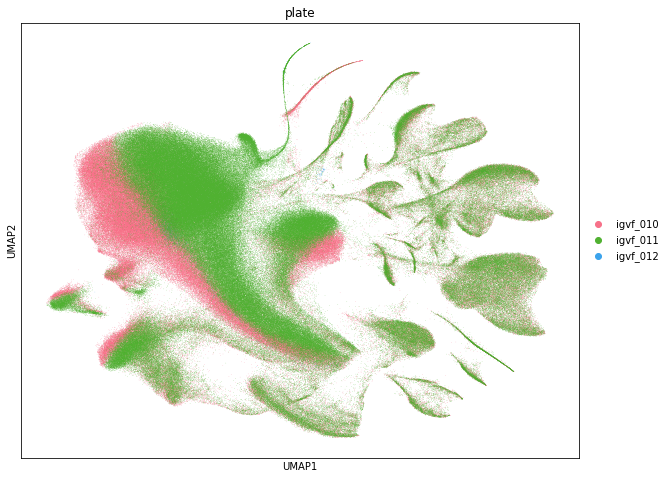

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


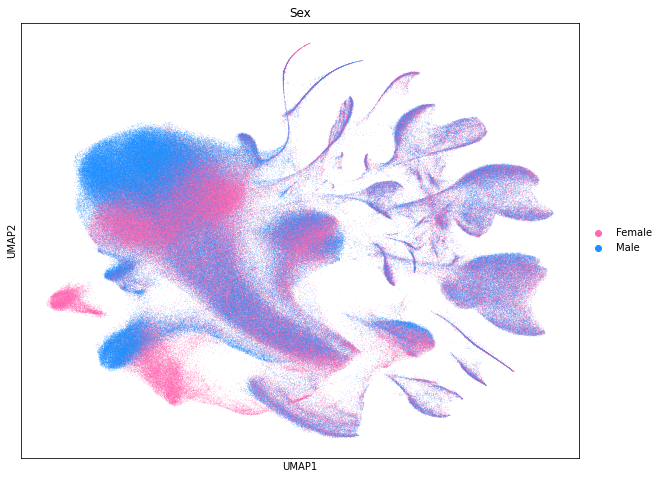

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


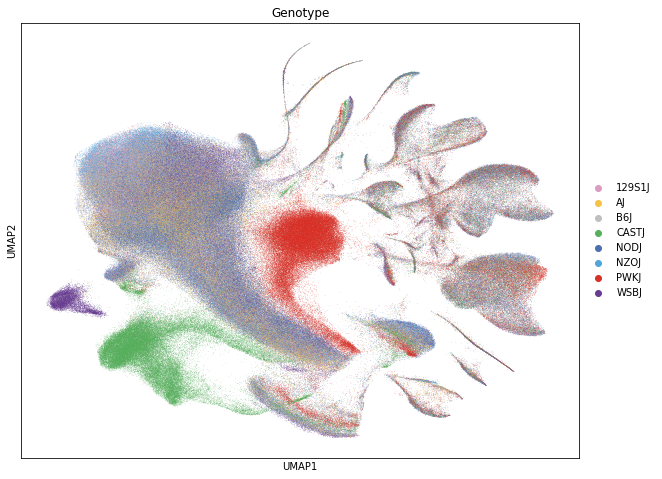

In [89]:
plt.rcParams['figure.figsize'] = (10, 8)

sc.pl.umap(adata, color=['leiden'], size=1, legend_loc = 'on data')

sc.pl.umap(adata, color=['plate'], size = 0.8, palette = plate_palette)

sc.pl.umap(adata, color=['Sex'], size = 0.8, palette = sex_palette)

sc.pl.umap(adata, color=['Genotype'], size = 0.8, palette = geno_palette)



# Check marker gene expression

In [90]:
marker_genes_dict = {
    "Adipocyte": ["Acsl1","Pparg","Adipoq","Pnpla2"],
    "FAP": ["Pdgfra","Cd34","Fap","Ly6a"],
    "Endothelial": ["Flt1","Pecam1","Cdh5","Kdr"],
    "Lymphatic_endothelial": ["Prox1"],
    "Macrophage": ["F13a1","Adgre1","Itgam","Ccr2"],
    "Lymphocyte": ["Ptprc","Ikzf1","Bcl11a","Themis","Il7r"],
    "Smooth_muscle": ["Myh11","Acta2","Tagln","Mylk","Eln","Myl6","Myl9"],
    "Schwann": ["Mpz","Sox10","S100b"],
    "Tenocyte": ["Mkx","Scx","Tnmd","Egr1","Dcn","Col1a1"],
    "MTJ": ["Col22a1","Lama2"],
    "NMJ": ["Etv5","Etv4","Chrne","Colq","Ncam1","Musk","Lrp4"],
    "Myonuclei": ["Mybpc1","Tnnt3","Ttn","Ckm","Lmna"],
    "Satellite": ["Pax7"],
    "Myocyte": ["Myod1","Myog","Myf5"],
    "Embryonic": ["Myh3"],
    "Perinatal": ["Myh8"],
    "Type1_Myonuclei": ["Myh7"],
    "Type2X_Myonuclei": ["Myh1"],
    "Type2A_Myonuclei": ["Myh2"],
    "Type2B_Myonuclei": ["Myh4","Pvalb","Mybpc2","Actn3"],
    "Cycling": ["Top2a","Mki67"],
    "Neuron": ["Snap25","Slc17a7","Meis2"],
    "Kidney": ["Uncx", "Nphs2", "Akr1c21","Slc12a1", "Slc12a3", "Trpv5", "Aqp2", "Atp6v1g3", "Egfl7"],

}



In [91]:
adata.var_names  = adata.var['gene_name']


categories: 0, 1, 2, etc.
var_group_labels: Adipocyte, FAP, Endothelial, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


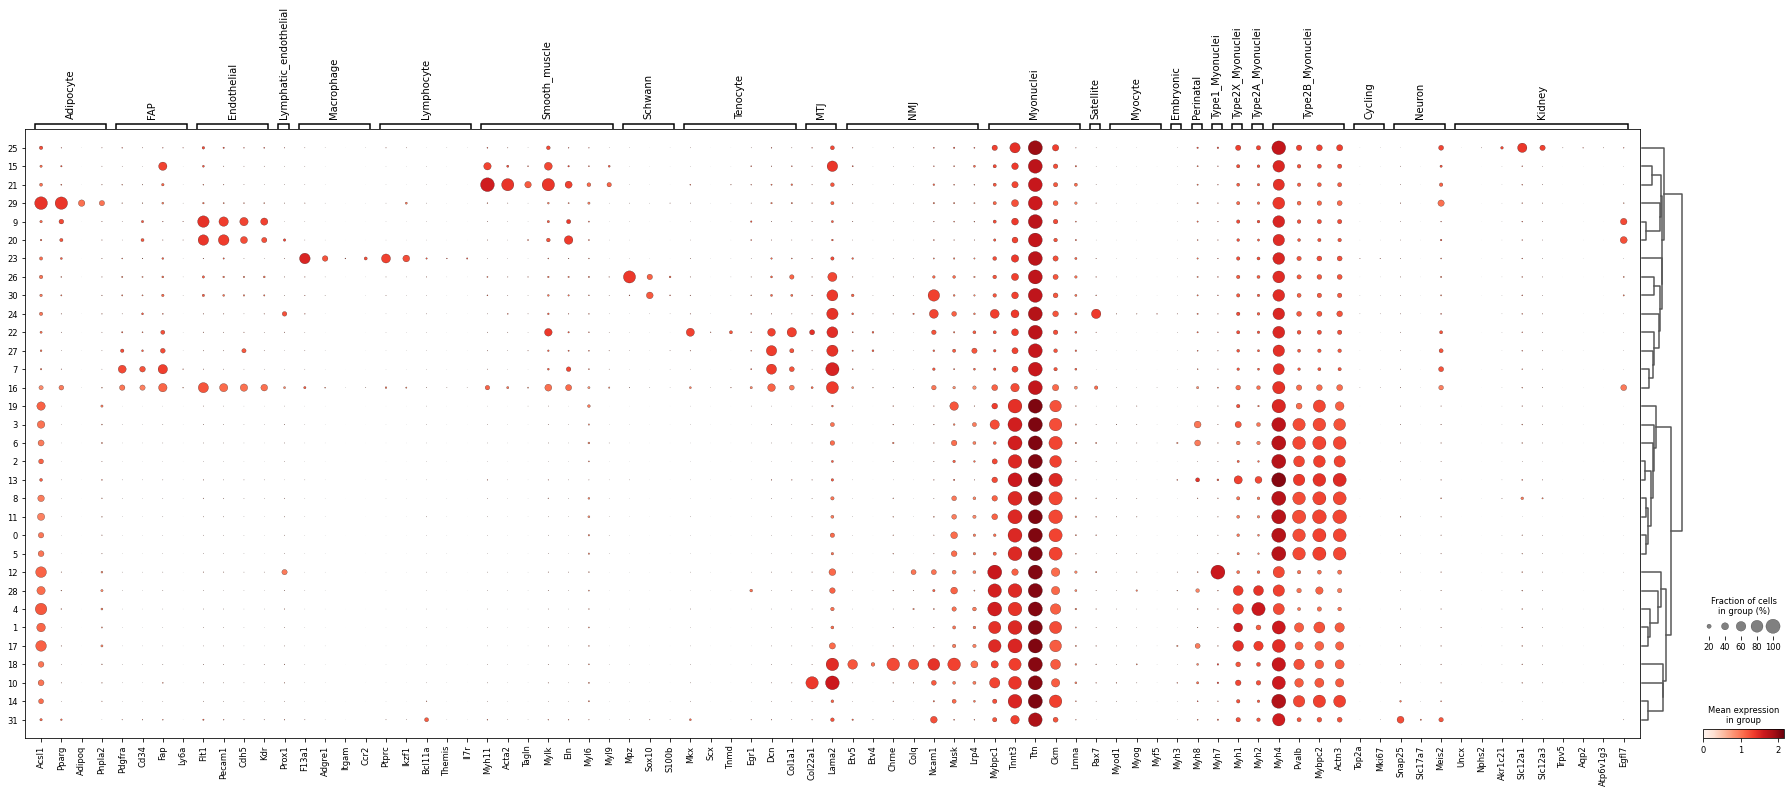

In [92]:
sc.pl.dotplot(adata, marker_genes_dict, 'leiden', mean_only_expressed = True,
              dendrogram=True, log=True)


In [93]:
smol_marker_genes_dict = {
    "Adipocyte": ["Acsl1"],
    "FAP": ["Pdgfra","Cd34"],
    "Endothelial": ["Flt1","Pecam1"],
    "Lymphatic_endothelial": ["Prox1"],
    "Macrophage": ["F13a1"],
    "Lymphocyte": ["Ikzf1"],
    "Smooth_muscle": ["Myh11"],
    "Schwann": ["Mpz","Sox10"],
    "Tenocyte": ["Dcn"],
    "MTJ": ["Col22a1"],
    "NMJ": ["Etv5"],
    "Satellite": ["Pax7"],
    "Embryonic": ["Myh3"],
    "Perinatal": ["Myh8"],
    "Type1_Myonuclei": ["Myh7"],
    "Type2X_Myonuclei": ["Myh1"],
    "Type2A_Myonuclei": ["Myh2"],
    "Type2B_Myonuclei": ["Myh4"],
    "Neuron": ["Snap25"],
    "Kidney": ["Akr1c21","Slc12a1"],

}



categories: 0, 1, 2, etc.
var_group_labels: Adipocyte, FAP, Endothelial, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


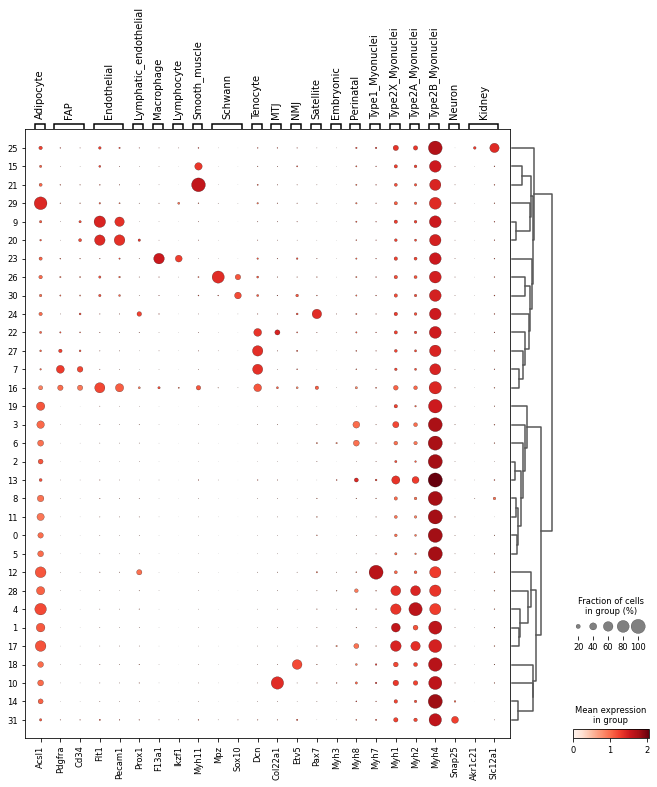

In [94]:
sc.pl.dotplot(adata, smol_marker_genes_dict, 'leiden', mean_only_expressed = True,
              dendrogram=True, log=True)


In [95]:


subtype_adata = adata[adata.obs['leiden'] == "24"].copy()
subtype_adata.layers["counts"] = subtype_adata.X

merged_df = pf.calc_total_counts(subtype_adata, obs_col='Mouse_Tissue_ID', layer='counts')


In [98]:
metadata = subtype_adata.obs[['Mouse_Tissue_ID', 'Genotype', 'Sex']].drop_duplicates()

# Read in the raw counts DataFrame
raw_counts_df = merged_df.transpose()

# Read in the GTF file and extract transcript lengths
transcript_lengths = {}  # Dictionary to store transcript lengths
with open('/share/crsp/lab/seyedam/share/igvf_splitseq/genomes_old/gencode.vM32.chr_patch_hapl_scaff.annotation.gtf') as gtf_file:
    for line in gtf_file:
        if line.startswith('#'):
            continue
        parts = line.strip().split('\t')
        if parts[2] == 'transcript':
            attributes = parts[8].split('; ')
            transcript_id = attributes[1].split('"')[1]
            gene_id = attributes[0].split('"')[1]
            transcript_length = int(parts[4]) - int(parts[3]) + 1
            if transcript_id not in transcript_lengths:
                transcript_lengths[transcript_id] = transcript_length


In [99]:
# Calculate library size
library_sizes = raw_counts_df.sum()

# Normalize counts to TPM
tpm_df = (raw_counts_df / library_sizes) * 1e6

# Adjust for transcript length
for transcript_id, length in transcript_lengths.items():
    if transcript_id in tpm_df.index:
        tpm_df.loc[transcript_id] /= length / 1000  # Convert length to kilobases

# Save TPM DataFrame to a file
#tpm_df.to_csv('tpm_normalized.csv')

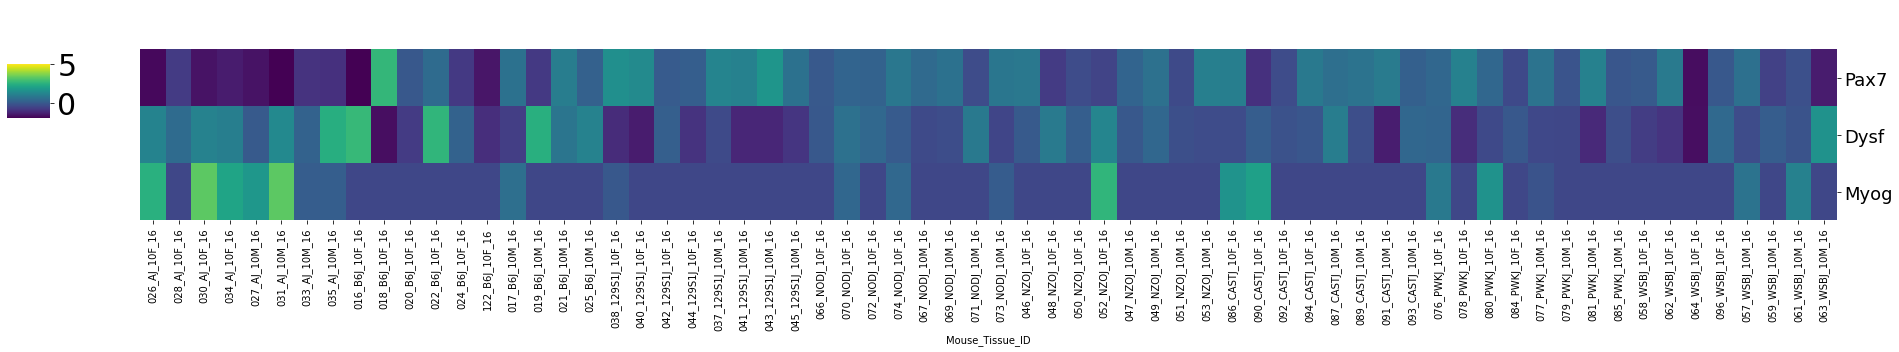

In [100]:
# Specify the order of genotypes and sexes
myogenesis = ['Pax7', 'Dysf','Myog']
filtered_tpm_df = tpm_df.loc[myogenesis]


genotypes = ['AJ', 'B6J', '129S1J', 'NODJ', 'NZOJ', 'CASTJ', 'PWKJ', 'WSBJ']
sexes = ["10F", "10M"]  

# Create a custom order for the columns based on genotypes and sexes
column_order = []
for genotype in genotypes:
    for sex in sexes:
        column_order.extend([col for col in filtered_tpm_df.columns if genotype in col and sex in col])

# Reorder the columns in the DataFrame
filtered_tpm_df = filtered_tpm_df[column_order]

# Use clustermap function in seaborn to make heatmap
cg = sns.clustermap(data=filtered_tpm_df,cmap="viridis",row_cluster=False,
                    col_cluster=False, z_score=0,  yticklabels=True,
                    figsize=(30, 5), vmin=-2, vmax=5)

cg.ax_row_dendrogram.set_visible(False)

cg.ax_heatmap.set_yticklabels(labels=cg.ax_heatmap.get_yticklabels(), rotation=0, fontsize=18)

# Adjust the font size of x-axis labels
plt.xticks(fontsize=10)


# Move the colorbar to the right-hand side and adjust its position
cbar_ax = cg.ax_cbar
cbar_ax.set_position([0.14, 0.66, 0.02, 0.15])  # Adjust the position of the colorbar
cbar_ax.tick_params(labelsize=30)  # Adjust the font size as needed




# Assign celltypes to clusters

In [39]:
annots = pd.read_csv("igvf_gastroc_annotations.csv")
annots['leiden'] = annots['leiden'].astype(str)
annotation_dict = annots.groupby('leiden').head(1).set_index('leiden')['celltype'].to_dict()


In [40]:
adata.obs['celltype'] = adata.obs['leiden'].map(annotation_dict)

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


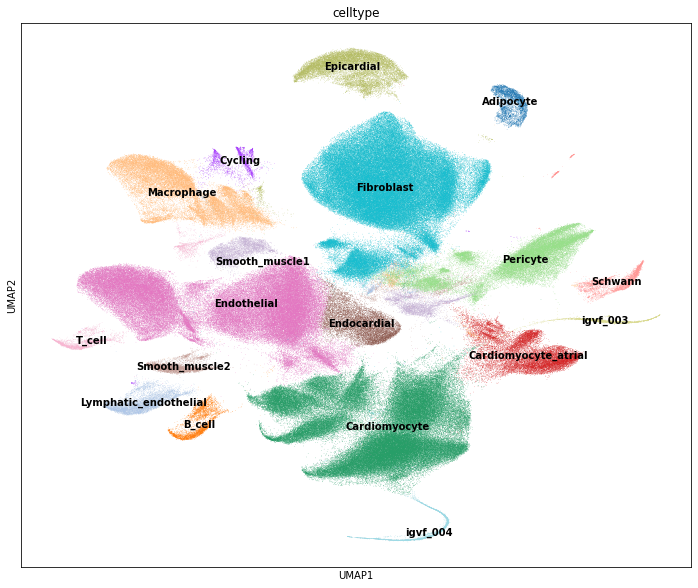

In [41]:
plt.rcParams['figure.figsize'] = (12, 10)

sc.pl.umap(adata, color=['celltype'], size=1, legend_loc = 'on data')


categories: Adipocyte, B_cell, Bleedthrough, etc.
var_group_labels: Adipocyte, Endothelial, Lymphatic_endothelial, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


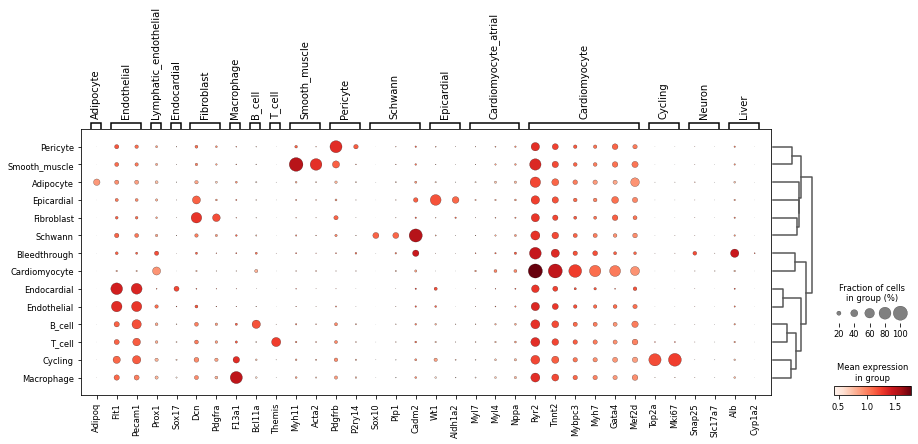

In [38]:
sc.pl.dotplot(adata, smol_marker_genes_dict, 'celltype', mean_only_expressed = True,
              dendrogram=True, log=True)


# Save annotated adata

In [42]:
adata.write_h5ad('../IGVF_analysis/annotated_tissues/Gastrocnemius_annotated.h5ad')
